In [1]:
import numpy as np
import pandas as pd
import random
import os
import openai
from tqdm import tqdm
import re
import time


In [2]:
def generate_type1_question(seq_len, ques_num):
    """
    seq_len: the length of the sequence (1 0 1 -> 3)
    ques_num: the number of questions
    """
    ques_list = []
    correct_ans = []
    elements = ["0", "1"]
    for _ in range(ques_num):
        seq_str = " ".join(random.choices(elements, k = seq_len))
        curr_ques_str = "Count the number of 1s in the following sequence: " + seq_str + "\nOutput the answer (arabic numerals) directly."
        ques_list.append(curr_ques_str)
        correct_ans.append(str(seq_str.count("1")))
    return ques_list, correct_ans

In [3]:
def generate_type2_question(seq_len, ques_num):
    ques_list = []
    correct_ans = []
    elements = ["a", "b", "c", "d"]
    for _ in range(ques_num):
        seq_str = " ".join(random.choices(elements, k = seq_len))
        curr_ques_str = "Reverse the following sequence of characters: " + seq_str + "\nOutput the answer (sequence) directly."
        ques_list.append(curr_ques_str)
        correct_ans.append(seq_str[::-1])
    return ques_list, correct_ans

In [4]:
def generate_palindrome(elements, k):
    palindrome = []
    for _ in range(k // 2):
        element = random.choice(elements)
        palindrome.append(element)
    reversed_palindrome = list(reversed(palindrome))
    if k % 2 == 1:
        element = random.choice(elements)
        palindrome.append(element)
    palindrome.extend(reversed_palindrome)
    return palindrome
def modify_to_not_palindrome(arr, elements):
    """
    for an array of characters, if it's palindrome, modify one element to make it not to be palindrome.
    the type of modified elements are restricted in the array elements.
    
    arr: input array that stores palindrome like ["a", "b", "a"]
    elements: choices of new modified element. In this case ["a", "b", "c", "d"]
    """
    while True:
        arr_str = " ".join(arr)
        if arr_str != arr_str[::-1]: 
            return arr
            break
        index = random.randint(0, len(arr) - 1)
        new_element = random.choice(elements)
        arr[index] = new_element
def generate_type3_question(seq_len, ques_num):
    ques_list = []
    correct_ans = []
    elements = ["a", "b", "c", "d"]
    for _ in range(ques_num // 2):
        palindrome_list = generate_palindrome(elements, k = seq_len)
        not_palindrome_list = modify_to_not_palindrome(palindrome_list.copy(), elements)
        palindrome_str = " ".join(palindrome_list)
        not_palindrome_str = " ".join(not_palindrome_list)
        yes_ques_str = "Determine whether the following sequence of characters is a palindrome: " + palindrome_str + "\nOutput the answer (Yes/No) directly."
        no_ques_str = "Determine whether the following sequence of characters is a palindrome: " + not_palindrome_str + "\nOutput the answer (Yes/No) directly."
        ques_list.extend([yes_ques_str, no_ques_str])
        correct_ans.extend(["Yes", "No"])
    return ques_list, correct_ans

In [5]:
def generate_testing_DataFrame(lower_n, upper_n):
    """
    generate all three types of questions with sequence length from lower_n to upper_n (both inclusive)
    (generate 100 questions per type per n)
    
    return: pd.DataFrame()
    """
    question_list = []
    answer_list = []
    question_type_list = []
    sequence_len = []
    for n in range(lower_n, upper_n + 1):
        q1, a1 = generate_type1_question(n, 100)
        q2, a2 = generate_type2_question(n, 100)
        q3, a3 = generate_type3_question(n, 100)
        question_list += q1 + q2 + q3
        answer_list += a1 + a2 + a3
        question_type_list += [1] * 100 + [2] * 100 + [3] * 100
        sequence_len += [n] * 300
    df = pd.DataFrame()
    df['question'] = question_list
    df['correct answer'] = answer_list
    df['type'] = question_type_list
    df['sequence_len'] = sequence_len
    return df

In [6]:
# get question dataframe
testing_df = generate_testing_DataFrame(8, 20)

In [7]:
# save file
testing_df.to_csv("GPT_Benchmark_dataset.csv")

In [167]:
# testing, get answers from gpt api

testing_df = pd.read_csv("GPT_Benchmark_dataset.csv")
questions = testing_df["question"].values
gpt_answers = []
for i in tqdm(range(len(questions))):
    try:
        responses = openai.ChatCompletion.create(
          model="gpt-3.5-turbo",
          messages = [{"role": "user", "content": questions[i]}],
          temperature=0,
          max_tokens=64,
        )
        resp = responses.choices[0].message.content
        gpt_answers.append((i, resp))
    except KeyboardInterrupt:
        raise KeyboardInterrupt
    except Exception as e:
        print(e)
        time.sleep(10)
        responses = openai.ChatCompletion.create(
          model="gpt-3.5-turbo",
          messages = [{"role": "user", "content": questions[i]}],
          temperature=0,
          max_tokens=64,
        )
        resp = responses.choices[0].message.content
        gpt_answers.append((i, resp))

  0%|                                                                                          | 0/492 [00:00<?, ?it/s]

Error communicating with OpenAI: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


 22%|█████████████████▏                                                              | 106/492 [04:26<04:01,  1.60it/s]

That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID c57a2c3b0bf2adeda4690d5034ea1a0e in your message.)


 34%|██████████████████████████▉                                                     | 166/492 [05:45<03:05,  1.76it/s]

That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 3806f8b08750d4045ccc42dbc6560290 in your message.)


 37%|█████████████████████████████▊                                                  | 183/492 [06:38<03:45,  1.37it/s]

That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 5820a746e5c45544f3742ac3a998b397 in your message.)


 50%|████████████████████████████████████████                                        | 246/492 [08:05<02:28,  1.65it/s]

That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 14a5b5b01008955a9ae024fff297d884 in your message.)


 61%|████████████████████████████████████████████████▊                               | 300/492 [09:47<08:49,  2.76s/it]

That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID fe45913cae954ac0813d0b8da98be99e in your message.)


 79%|███████████████████████████████████████████████████████████████                 | 388/492 [15:08<04:45,  2.75s/it]

Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 24 May 2023 01:44:31 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7cc1d2fbeec50fd9-LAX', 'alt-svc': 'h3=":443"; ma=86400, h3-29=":443"; ma=86400'}


 81%|████████████████████████████████████████████████████████████████▉               | 399/492 [20:49<05:55,  3.82s/it]

That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID a3248a4c3e26ab30bb5d8d578ba39136 in your message.)


 87%|█████████████████████████████████████████████████████████████████████▌          | 428/492 [21:50<00:35,  1.81it/s]

That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 4229d8a8a1a3749bbc327f92a602e583 in your message.)


 91%|█████████████████████████████████████████████████████████████████████████▏      | 450/492 [22:43<00:28,  1.45it/s]

The server had an error while processing your request. Sorry about that!


100%|████████████████████████████████████████████████████████████████████████████████| 492/492 [23:24<00:00,  2.86s/it]


In [227]:
# since gpt_answer contains tuples like (index, answer), we get the pure answer here
pure_answer = [e[1] for e in gpt_answers]

In [228]:
# attach gpt generated answer to the dataframe & save
testing_df["gpt answer"] = pure_answer
testing_df = testing_df[["question", "correct answer", "type", "sequence_len", "gpt answer"]]
testing_df.to_csv("gpt_turbo.csv")

In [5]:
# data cleaning for type 1 question, we only want arabic numerals 
df = pd.read_csv("GPT_Benchmark_dataset_with_gpt3-5turbo_answer.csv")
type_1_df = df[df["type"] == 1]
type_1_df["gpt answer"] = type_1_df["gpt answer"].apply(lambda x: re.sub(r"\D", "", x.replace("1s", "")))
resp_type_1 = type_1_df.groupby("sequence_len").apply(lambda x: np.mean(np.array(x["correct answer"].values) == np.array(x["gpt answer"].values)))

C:\Users\yongc\AppData\Local\Temp\ipykernel_42020\3540016948.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_1_df["gpt answer"] = type_1_df["gpt answer"].apply(lambda x: re.sub(r"\D", "", x.replace("1s", "")))


In [6]:
# data cleaning for type 2 question, we only want resulting sequence 
type_2_df = df[df["type"] == 2]
type_2_df["gpt answer"] = type_2_df["gpt answer"].apply(lambda x: re.sub(r'[^a-d]', '', x.split("reversed is")[-1]))
type_2_df["correct answer"] = type_2_df["correct answer"].apply(lambda x: re.sub(r'[^a-d]', '', x))
resp_type_2 = type_2_df.groupby("sequence_len").apply(lambda x: np.mean(np.array(x["correct answer"].values) == np.array(x["gpt answer"].values)))

C:\Users\yongc\AppData\Local\Temp\ipykernel_42020\2403957675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_2_df["gpt answer"] = type_2_df["gpt answer"].apply(lambda x: re.sub(r'[^a-d]', '', x.split("reversed is")[-1]))
C:\Users\yongc\AppData\Local\Temp\ipykernel_42020\2403957675.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_2_df["correct answer"] = type_2_df["correct answer"].apply(lambda x: re.sub(r'[^a-d]', '', x))


In [7]:
# data cleaning for type 3 question, we only want "Yes"/"No"
type_3_df = df[df["type"] == 3]
def filter_ans_3(x):
    if "Yes" in x:
        return "Yes"
    else:
        return "No"
type_3_df["gpt answer"] = type_3_df["gpt answer"].apply(lambda x: filter_ans_3(x))     
resp_type_3 = type_3_df.groupby("sequence_len").apply(lambda x: np.mean(np.array(x["correct answer"].values) == np.array(x["gpt answer"].values)))

C:\Users\yongc\AppData\Local\Temp\ipykernel_42020\1009582429.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_3_df["gpt answer"] = type_3_df["gpt answer"].apply(lambda x: filter_ans_3(x))


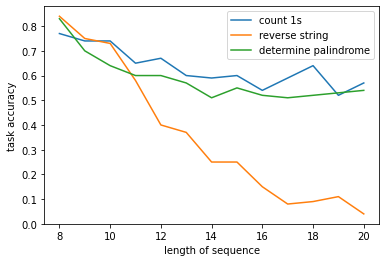

In [8]:
# plot the trend
import matplotlib.pyplot as plt
plt.plot(resp_type_1.index, resp_type_1.values, label = "count 1s")
plt.plot(resp_type_2.index, resp_type_2.values, label = "reverse string")
plt.plot(resp_type_3.index, resp_type_3.values, label = "determine palindrome")
plt.xlabel("length of sequence")
plt.ylabel("task accuracy")
plt.legend()
plt.show()

In [10]:
# plot the table
numer_results_df = pd.concat([resp_type_1, resp_type_2, resp_type_3], axis=1)
numer_results_df.rename(columns = {0: "count 1s", 1: "reverse string", 2: "determine palindrome"})

,count 1s,reverse string,determine palindrome
sequence_len,,,
8,0.77,0.84,0.83
9,0.74,0.75,0.70
10,0.74,0.73,0.64
11,0.65,0.58,0.60
12,0.67,0.40,0.60
13,0.60,0.37,0.57
14,0.59,0.25,0.51
15,0.60,0.25,0.55
16,0.54,0.15,0.52


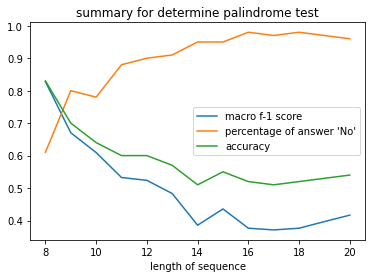

In [25]:
from sklearn import metrics
macro_f1 = type_3_df.groupby("sequence_len").apply(lambda x: metrics.f1_score(x["correct answer"], x["gpt answer"], average='macro'))
percent_No = type_3_df.groupby("sequence_len").apply(lambda x: np.mean(x["gpt answer"] == "No"))
plt.plot(macro_f1.index, macro_f1.values, label = "macro f-1 score")
plt.plot(percent_No.index, percent_No.values, label = "percentage of answer 'No'")
plt.plot(resp_type_3.index, resp_type_3.values, label = "accuracy")
plt.xlabel("length of sequence")
plt.title("summary for determine palindrome test")
plt.legend()
plt.show()
#f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
#f1_score_macro = metrics.f1_score(targets, outputs, average='macro')

In [24]:
type_3_summary = pd.concat([macro_f1, percent_No, resp_type_3], axis=1)
type_3_summary.rename(columns = {0: "macro f1", 1: "percentage of 'No'", 2: "accuracy"})

,macro f1,percentage of 'No',accuracy
sequence_len,,,
8,0.827918,0.61,0.83
9,0.670330,0.80,0.70
10,0.609375,0.78,0.64
11,0.532492,0.88,0.60
12,0.523810,0.90,0.60
13,0.483111,0.91,0.57
14,0.385580,0.95,0.51
15,0.435737,0.95,0.55
16,0.376299,0.98,0.52


In [8]:
def calculate_probability(sequence):
  probability = 1
  letters = {'o': 2, 'y': 4, 'v': 4}
  for letter in sequence:
    probability *= letters[letter] / sum(letters.values())
    letters[letter] -= 1
  return probability

print(calculate_probability('yovy')) # 0.064

0.019047619047619046


In [19]:
# Solve 0 = 5*y + 51 - 6 for y
y = (51 - 6) / 5

# Let w = 17 + y
w = 17 + y

# Solve 0 = -3*b + w*b - 20 for b
b = (20 + 3) / (w - 3)

# Solve b = -0*c - 2*c for c
c = -b / 2

# Return the answer to the original problem
print(c)

-0.5


No
